## Setting Up:

In [1]:
import pandas as pd
import os
import warnings
from tqdm.notebook import tqdm
import re
from calendar import month_abbr
import matplotlib.pyplot as plt
import seaborn as sns
from cmcrameri import cm
import xarray as xr
import massbalancemachine as mbm
from collections import defaultdict
import logging

from scripts.helpers import *
from scripts.glamos_preprocess import *
from scripts.plots import *
from scripts.config_CH import *
from scripts.xgb_helpers import *

warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

cfg = mbm.SwitzerlandConfig()

In [2]:
seed_all(cfg.seed)
free_up_cuda()

# Plot styles:
path_style_sheet = 'scripts/example.mplstyle'
plt.style.use(path_style_sheet)
colors = get_cmap_hex(cm.batlow, 10)
color_dark_blue = colors[0]
color_pink = '#c51b7d'

# RGI Ids:
# Read rgi ids:
rgi_df = pd.read_csv(path_glacier_ids, sep=',')
rgi_df.rename(columns=lambda x: x.strip(), inplace=True)
rgi_df.sort_values(by='short_name', inplace=True)
rgi_df.set_index('short_name', inplace=True)


vois_climate = [
    't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10'
]

vois_topographical = [
    # "aspect", # OGGM
    # "slope", # OGGM 
    "aspect_sgi", # SGI
    "slope_sgi", # SGI
    "hugonnet_dhdt", # OGGM
    "consensus_ice_thickness", # OGGM
    "millan_v", # OGGM
]

## Read GL data:

In [3]:
data_glamos = pd.read_csv(path_PMB_GLAMOS_csv + 'CH_wgms_dataset_all.csv')

print('Number of glaciers:', len(data_glamos['GLACIER'].unique()))
print('Number of winter and annual samples:', len(data_glamos))
print('Number of annual samples:',
      len(data_glamos[data_glamos.PERIOD == 'annual']))
print('Number of winter samples:',
      len(data_glamos[data_glamos.PERIOD == 'winter']))

# Capitalize glacier names:
glacierCap = {}
for gl in data_glamos['GLACIER'].unique():
    if isinstance(gl, str):  # Ensure the glacier name is a string
        if gl.lower() == 'claridenu':
            glacierCap[gl] = 'Clariden_U'
        elif gl.lower() == 'claridenl':
            glacierCap[gl] = 'Clariden_L'
        else:
            glacierCap[gl] = gl.capitalize()
    else:
        print(f"Warning: Non-string glacier name encountered: {gl}")

data_glamos.head(2)

Number of glaciers: 31
Number of winter and annual samples: 31875
Number of annual samples: 7587
Number of winter samples: 24288


,YEAR,POINT_ID,GLACIER,FROM_DATE,TO_DATE,POINT_LAT,POINT_LON,POINT_ELEVATION,POINT_BALANCE,PERIOD,RGIId,aspect,slope,topo,hugonnet_dhdt,consensus_ice_thickness,millan_v,aspect_sgi,slope_sgi,topo_sgi
0,2006,adler_28,adler,20051017,20061011,46.010637,7.855896,3096.507742,-2.592,annual,RGI60-11.02764,254.483669,19.483581,3039.0,-1.504815,43.181839,3.591626,286.843880,20.604390,3018.033333
1,2006,adler_54,adler,20051017,20061011,46.010052,7.858628,3141.506520,-2.502,annual,RGI60-11.02764,273.466595,12.549861,3091.0,-0.970061,41.090096,0.975349,258.181463,12.582387,3077.711111


### Glaciers with pot. radiadation data:

In [4]:
# Glaciers with data of potential clear sky radiation
# Format to same names as stakes:
glDirect = np.sort([
    re.search(r'xr_direct_(.*?)\.nc', f).group(1)
    for f in os.listdir(path_pcsr + 'csv/')
])

restgl = np.sort(Diff(list(glDirect), list(data_glamos.GLACIER.unique())))

print('Glaciers with potential clear sky radiation data:\n', glDirect)
print('Number of glaciers:', len(glDirect))
print('Glaciers without potential clear sky radiation data:\n', restgl)

# Filter out glaciers without data:
data_glamos = data_glamos[data_glamos.GLACIER.isin(glDirect)]

# Look at the data of the ERA5 dataset:
xr.open_dataset(path_ERA5_raw + 'era5_monthly_averaged_data.nc')

Glaciers with potential clear sky radiation data:
 ['adler' 'albigna' 'aletsch' 'allalin' 'arolla' 'basodino' 'clariden'
 'corbassiere' 'corvatsch' 'findelen' 'forno' 'gietro' 'gorner' 'gries'
 'hohlaub' 'joeri' 'limmern' 'morteratsch' 'murtel' 'oberaar' 'otemma'
 'pers' 'pizol' 'plainemorte' 'plattalva' 'rhone' 'sanktanna'
 'schwarzbach' 'schwarzberg' 'sexrouge' 'silvretta' 'taelliboden' 'tortin'
 'tsanfleuron']
Number of glaciers: 34
Glaciers without potential clear sky radiation data:
 ['arolla' 'joeri' 'pers']


<xarray.Dataset> Size: 2GB
Dimensions:    (longitude: 201, latitude: 51, expver: 2, time: 895)
Coordinates:
  * longitude  (longitude) float32 804B 0.0 0.1 0.2 0.3 ... 19.7 19.8 19.9 20.0
  * latitude   (latitude) float32 204B 50.0 49.9 49.8 49.7 ... 45.2 45.1 45.0
  * expver     (expver) int32 8B 1 5
  * time       (time) datetime64[ns] 7kB 1950-01-01 1950-02-01 ... 2024-07-01
Data variables: (12/14)
    u10        (time, expver, latitude, longitude) float64 147MB ...
    v10        (time, expver, latitude, longitude) float64 147MB ...
    t2m        (time, expver, latitude, longitude) float64 147MB ...
    fal        (time, expver, latitude, longitude) float64 147MB ...
    snowc      (time, expver, latitude, longitude) float64 147MB ...
    rsn        (time, expver, latitude, longitude) float64 147MB ...
    ...         ...
    smlt       (time, expver, latitude, longitude) float64 147MB ...
    slhf       (time, expver, latitude, longitude) float64 147MB ...
    str        (time, expver, latitude, longitude) float64 147MB ...
    sshf       (time, expver, latitude, longitude) float64 147MB ...
    ssrd       (time, expver, latitude, longitude) float64 147MB ...
    tp         (time, expver, latitude, longitude) float64 147MB ...
Attributes:
    Conventions:  CF-1.6
    history:      2024-08-08 11:30:10 GMT by grib_to_netcdf-2.24.0: /opt/ecmw...

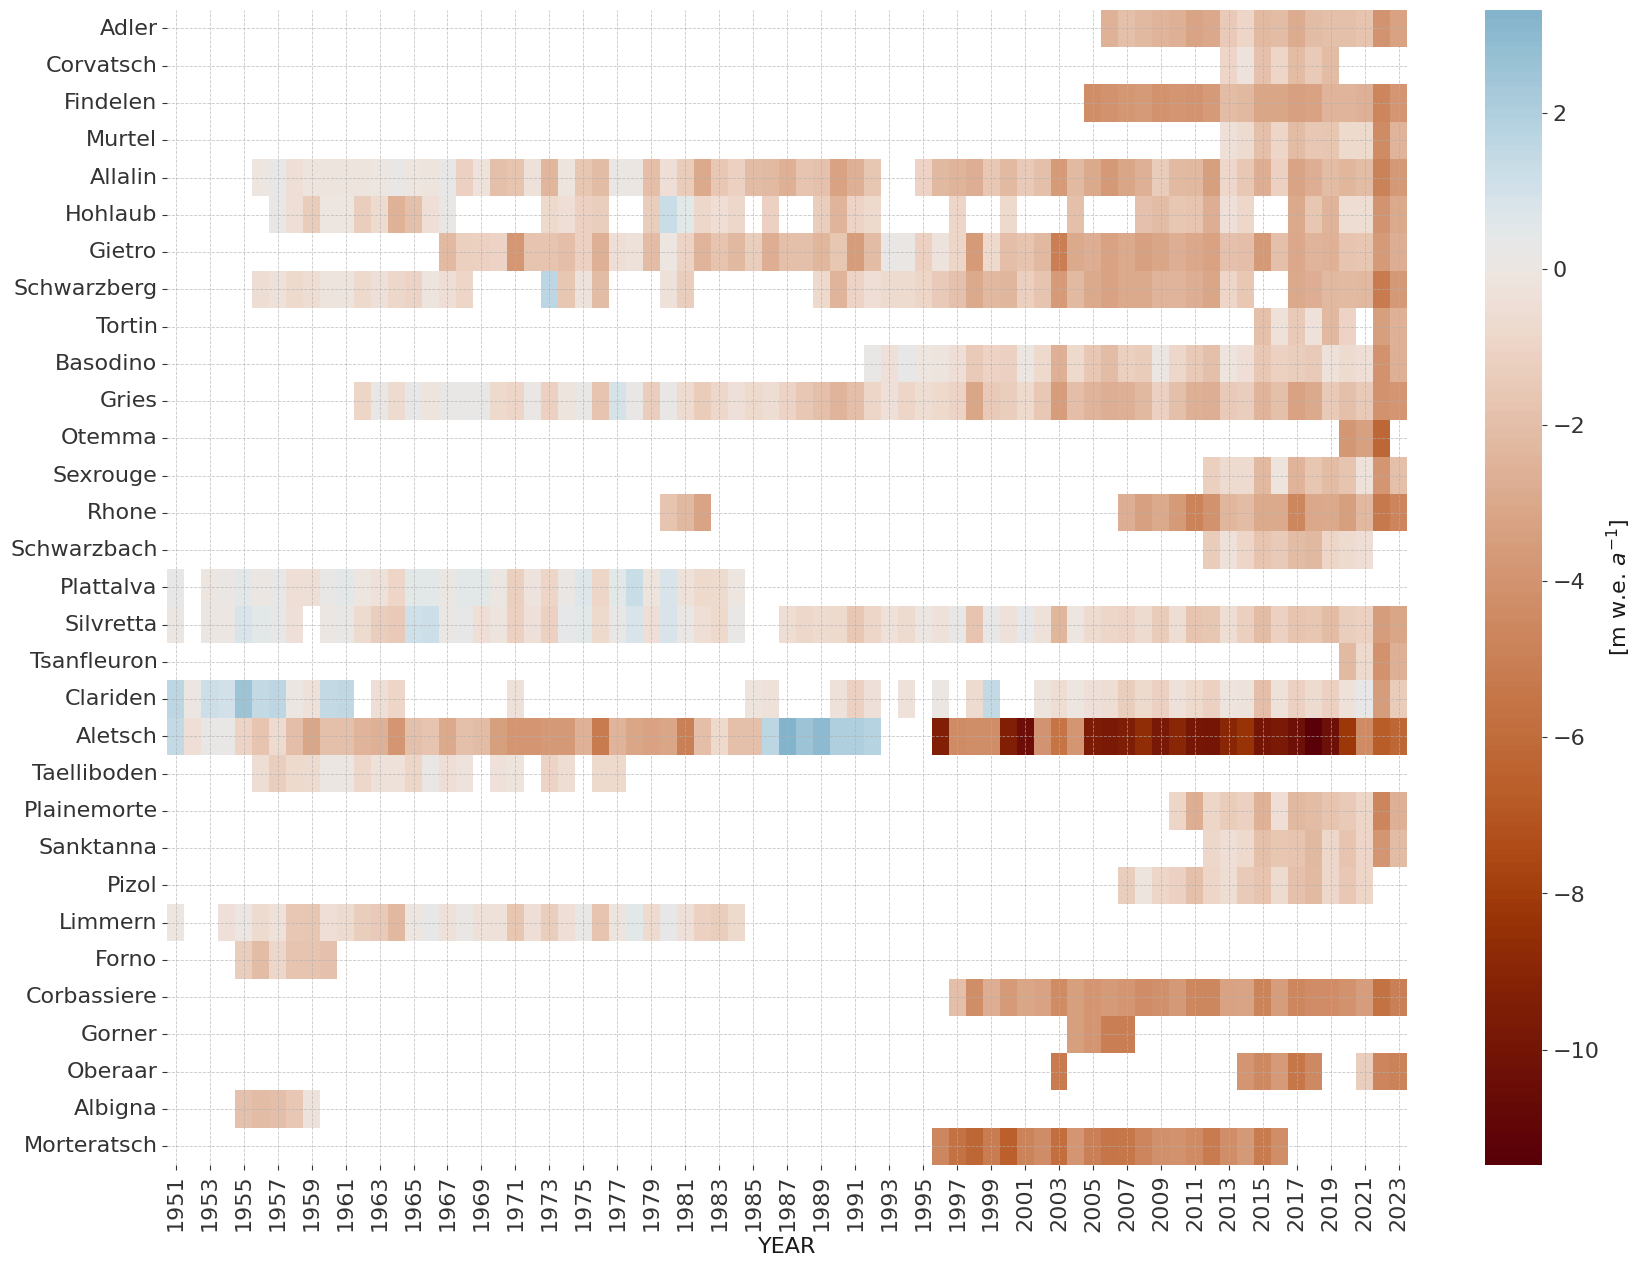

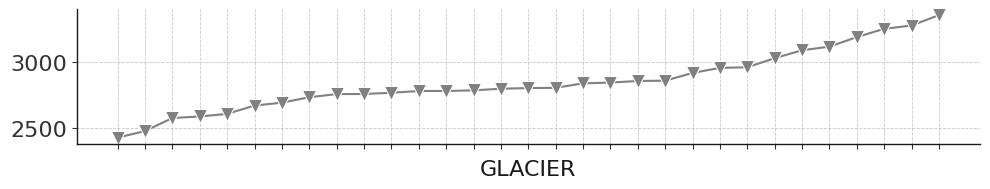

In [5]:
# Heatmap of mean mass balance per glacier:
# Get the mean mass balance per glacier
data_glamos_ = data_glamos.copy()
data_glamos_['GLACIER'] = data_glamos['GLACIER'].apply(lambda x: glacierCap[x])

mean_mb_per_glacier = data_glamos_.groupby(
    ['GLACIER', 'YEAR', 'PERIOD'])['POINT_BALANCE'].mean().reset_index()
mean_mb_per_glacier = mean_mb_per_glacier[mean_mb_per_glacier['PERIOD'] ==
                                          'annual']

matrix = mean_mb_per_glacier.pivot(
    index='GLACIER', columns='YEAR',
    values='POINT_BALANCE').sort_values(by='GLACIER')

# get elevation of glaciers:
gl_per_el = data_glamos_.groupby(['GLACIER'])['POINT_ELEVATION'].mean()
gl_per_el = gl_per_el.sort_values(ascending=False)

# Order matrix:
matrix = matrix.loc[gl_per_el.index]
matrix.index = pd.Categorical(matrix.index,
                              categories=matrix.index,
                              ordered=True)

# Plot heatmap:
fig = plt.figure(figsize=(20, 15))
ax = plt.subplot(1, 1, 1)
heatmap = sns.heatmap(
    data=matrix,
    center=0,
    cmap=cm.vik_r,
    cbar_kws={'label': '[m w.e. $a^{-1}$]'},
    ax=ax,
)

# Plot elevation:
fig = plt.figure(figsize=(10, 2))
ax = plt.subplot(1, 1, 1)
sns.lineplot(gl_per_el.sort_values(ascending=True),
             ax=ax,
             color='gray',
             marker='v')
ax.set_xticklabels('', rotation=90)
ax.set_ylabel('')
plt.tight_layout()

## Input data:
### Input dataset:

In [6]:
# Initialize logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')

# Transform data to monthly format (run or load data):
paths = {
    'csv_path': path_PMB_GLAMOS_csv,
    'era5_climate_data': path_ERA5_raw + 'era5_monthly_averaged_data.nc',
    'geopotential_data': path_ERA5_raw + 'era5_geopotential_pressure.nc',
    'radiation_save_path': path_pcsr + 'csv/'
}
RUN = False
dataloader_gl = process_or_load_data(run_flag=RUN,
                                     data_glamos=data_glamos,
                                     paths=paths,
                                     cfg=cfg,
                                     vois_climate=vois_climate,
                                     vois_topographical=vois_topographical)
data_monthly = dataloader_gl.data

2025-02-25 12:21:29,722 - INFO - Loaded preprocessed data.
2025-02-25 12:21:29,724 - INFO - Number of monthly rows: 280720
2025-02-25 12:21:29,750 - INFO - Number of annual rows: 90870
2025-02-25 12:21:29,782 - INFO - Number of winter rows: 189850


### Correction for elevation difference:

Mean Cprec: 2.3, Mean T_off: 2.03


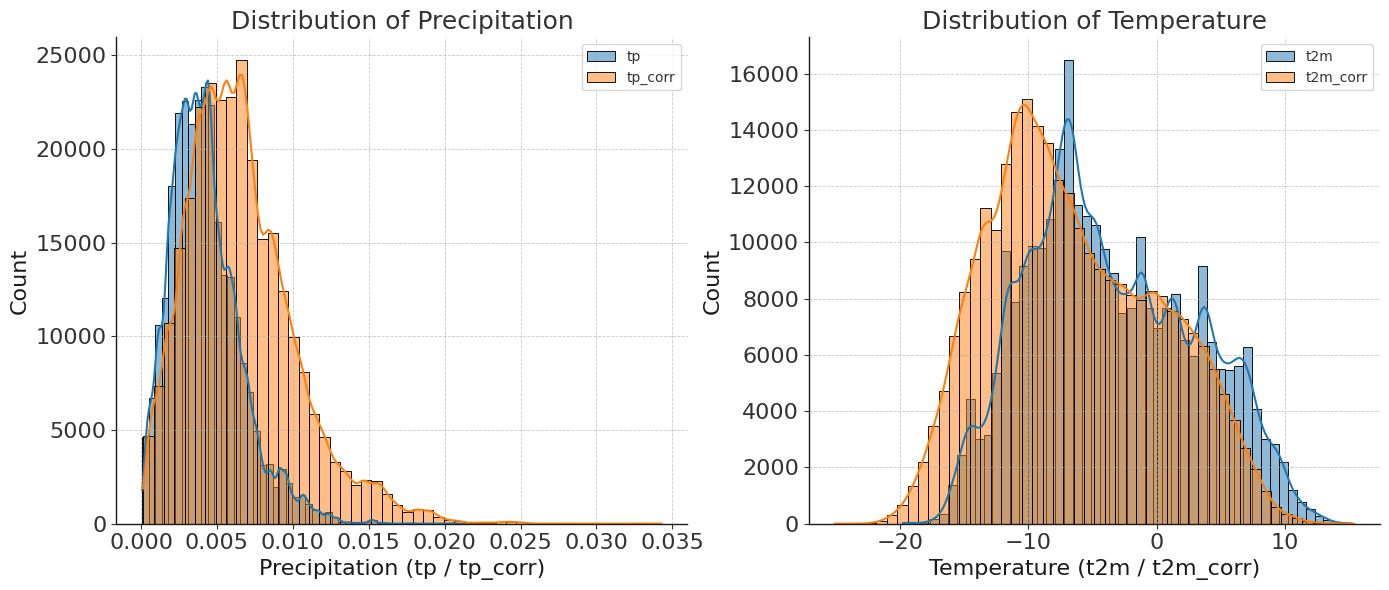

In [7]:
# Load and preprocess GloGEM factors
path_glogem_factors = os.path.join(path_glogem, 'reference_run_GloGEM2024.csv')
glogem_factors = pd.read_csv(path_glogem_factors)
glogem_factors.rename(columns={'ID': 'RGIId'}, inplace=True)
glogem_factors['RGIId'] = glogem_factors['RGIId'].apply(
    lambda x: format_rgi_code(x))

c_prec_dic, t_off_dic = {}, {}
for gl in data_monthly.GLACIER.unique():
    rgi_gl = data_monthly[data_monthly.GLACIER == gl].RGIId.unique()[0]
    factor_gl = glogem_factors[glogem_factors.RGIId == rgi_gl]
    c_prec_dic[gl] = factor_gl['Cprec'].values[0]
    t_off_dic[gl] = factor_gl['T_off'].values[0]

# Mean of dic values
mean_c_prec = np.max(list(c_prec_dic.values()))
mean_t_off = np.max(list(t_off_dic.values()))
print(f"Mean Cprec: {mean_c_prec}, Mean T_off: {mean_t_off}")

# Correct t2m and tp for elevation
dataloader_gl.correct_for_elevation()

# Plot the distribution of corrected and uncorrected precipitation and temperature
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Precipitation
sns.histplot(data_monthly['tp'],
             bins=50,
             kde=True,
             label='tp',
             alpha=0.5,
             ax=axes[0])
sns.histplot(data_monthly['tp_corr'],
             bins=50,
             kde=True,
             label='tp_corr',
             alpha=0.5,
             ax=axes[0])
axes[0].set_title('Distribution of Precipitation')
axes[0].set_xlabel('Precipitation (tp / tp_corr)')
axes[0].legend()

# Temperature
sns.histplot(data_monthly['t2m'],
             bins=50,
             kde=True,
             label='t2m',
             alpha=0.5,
             ax=axes[1])
sns.histplot(data_monthly['t2m_corr'],
             bins=50,
             kde=True,
             label='t2m_corr',
             alpha=0.5,
             ax=axes[1])
axes[1].set_title('Distribution of Temperature')
axes[1].set_xlabel('Temperature (t2m / t2m_corr)')
axes[1].legend()

plt.tight_layout()
plt.show()

### Feature correlation:

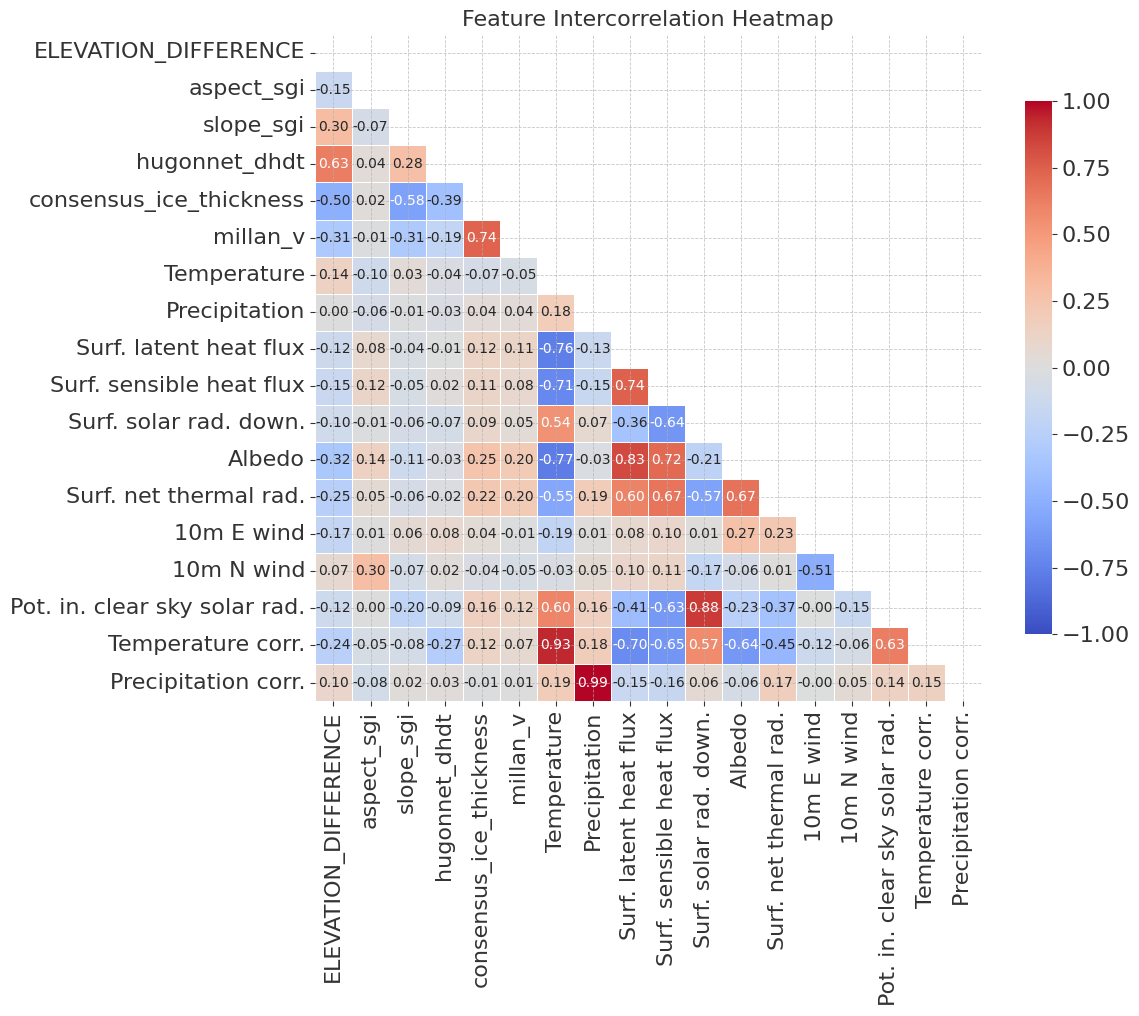

In [8]:
# Prepare data for correlation analysis
df = dataloader_gl.data.copy().dropna()

# Define the columns to keep
columns_to_keep = [
    col for col in df.columns if col not in [
        'GLACIER', 'PERIOD', 'YEAR', 'POINT_LON', 'POINT_LAT', 'POINT_BALANCE',
        'ALTITUDE_CLIMATE', 'POINT_ELEVATION', 'RGIId', 'POINT_ID', 'ID',
        'N_MONTHS', 'MONTHS'
    ]
]
df = df[columns_to_keep]

# Rename columns based on long names (if applicable)
df.rename(columns=vois_climate_long_name, inplace=True)

# Compute correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(12, 10))

# Plot the heatmap
sns.heatmap(
    corr,
    mask=mask,
    cmap='coolwarm',
    vmax=1,
    vmin=-1,
    center=0,
    annot=True,  # Add correlation values
    fmt=".2f",
    square=True,
    linewidths=.5,
    cbar_kws={"shrink": 0.8})

# Enhance readability
plt.title("Feature Intercorrelation Heatmap", fontsize=16)
plt.tight_layout()

# Show the plot
plt.show()

### Num. meas per year:

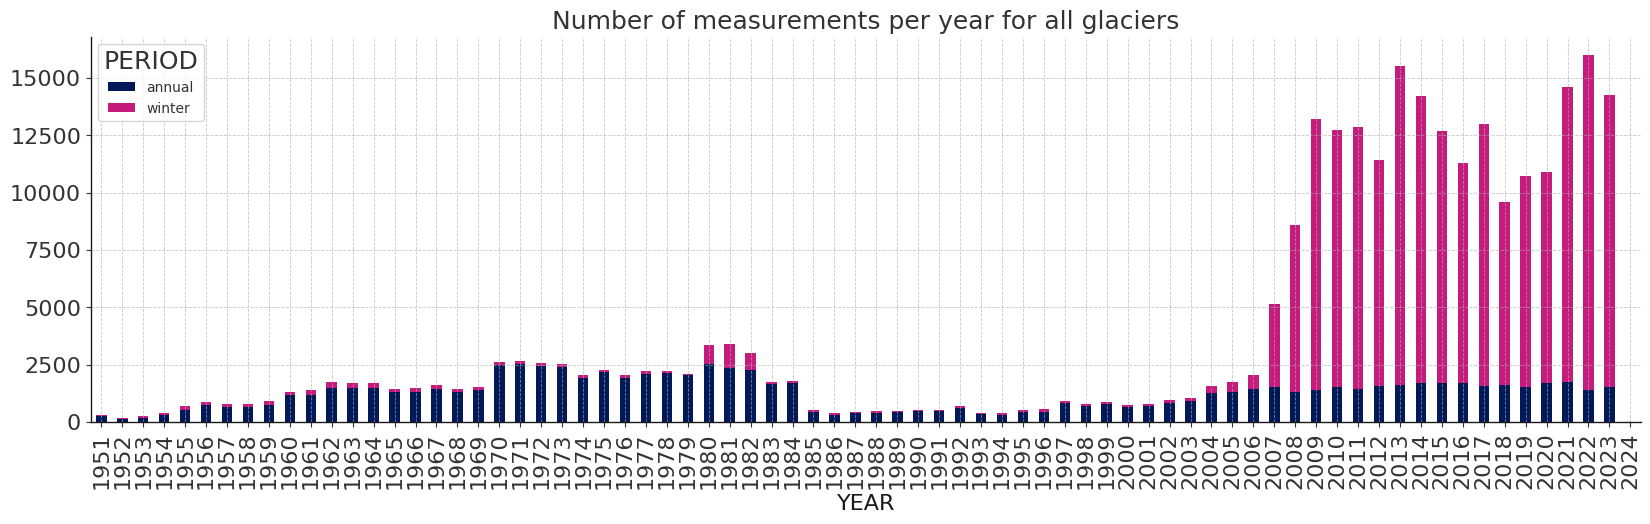

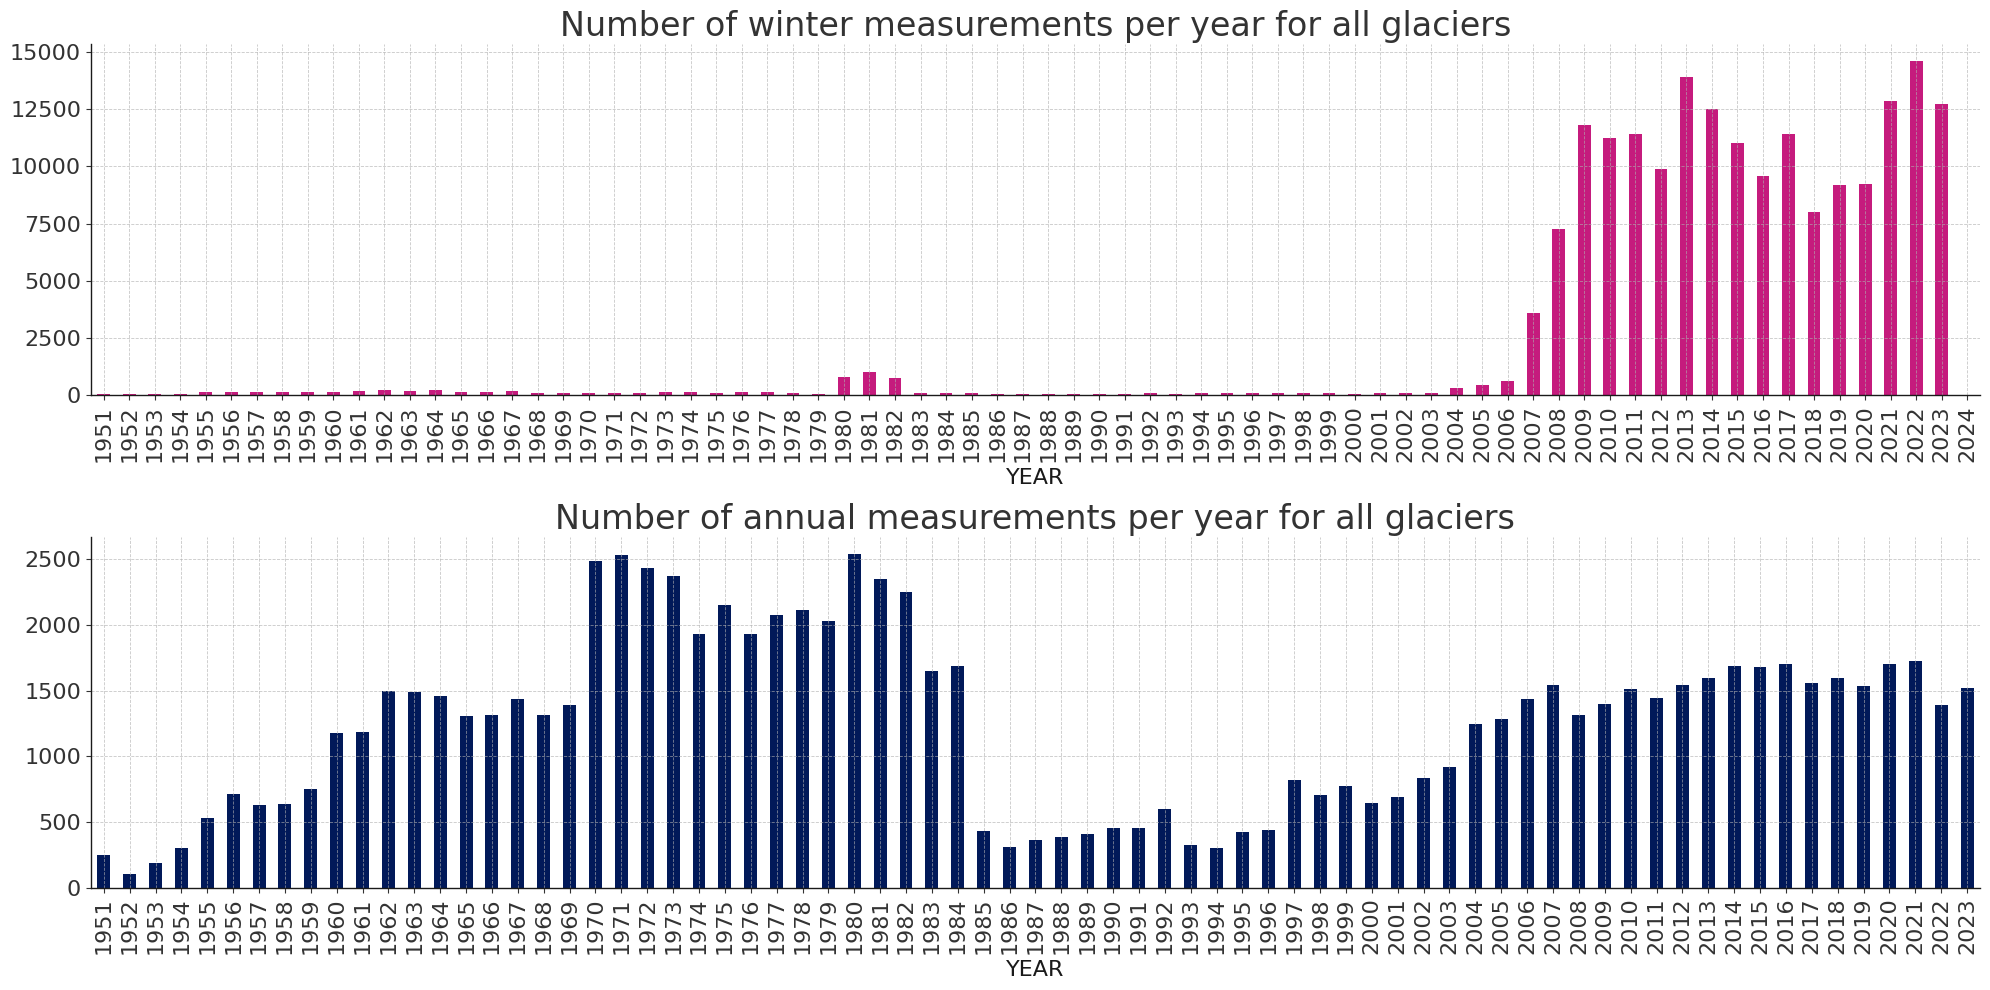

In [9]:
# Number of measurements per year:
dataloader_gl.data.groupby(['YEAR', 'PERIOD']).size().unstack().plot(
    kind='bar',
    stacked=True,
    figsize=(20, 5),
    color=[color_dark_blue, color_pink])
plt.title('Number of measurements per year for all glaciers')

# Plot winter and annual separately:
fig, axs = plt.subplots(2, 1, figsize=(20, 10), sharey=False)
dataloader_gl.data[dataloader_gl.data.PERIOD == 'winter'].groupby(
    ['YEAR', 'PERIOD']).size().unstack().plot(kind='bar',
                                              ax=axs[0],
                                              color=[color_pink],
                                              legend=False)
axs[0].set_title('Number of winter measurements per year for all glaciers',
                 fontsize=24)

dataloader_gl.data[dataloader_gl.data.PERIOD == 'annual'].groupby(
    ['YEAR', 'PERIOD']).size().unstack().plot(kind='bar',
                                              stacked=True,
                                              ax=axs[1],
                                              color=[color_dark_blue],
                                              legend=False)
axs[1].set_title('Number of annual measurements per year for all glaciers',
                 fontsize=24)
plt.tight_layout()

### Sanity checks:

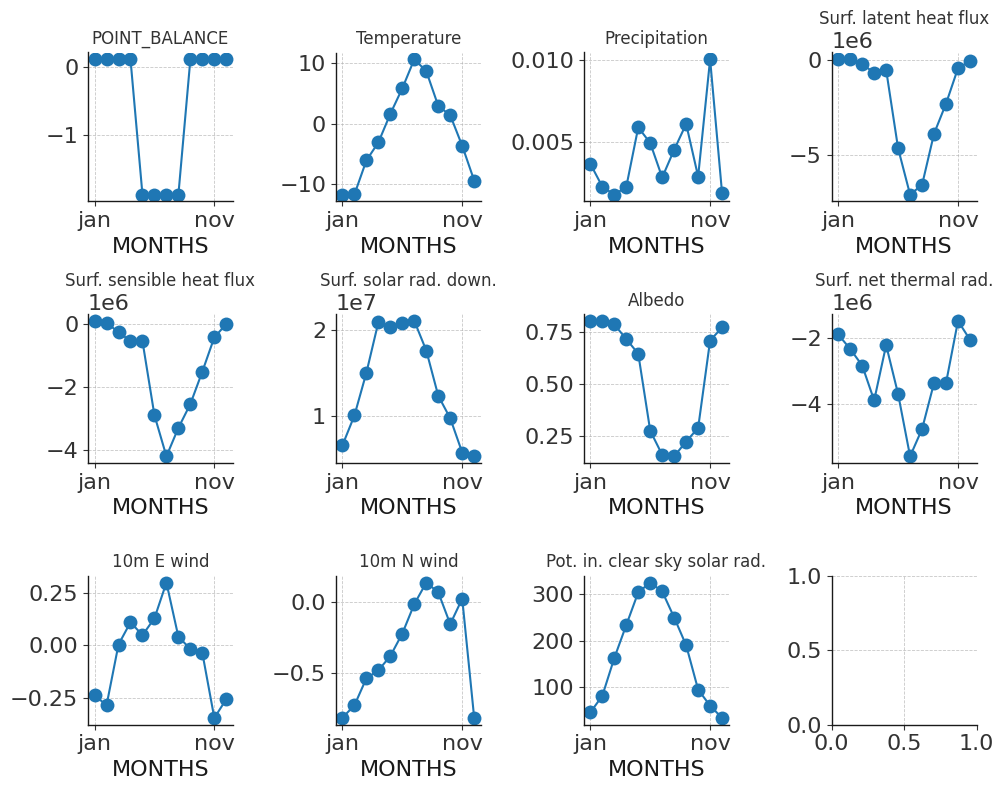

In [10]:
# Sanity check of variables:
df = dataloader_gl.data
var_to_plot = ['POINT_BALANCE'] + vois_climate + ['pcsr']
df = df[(df.GLACIER == 'corvatsch') & (df.YEAR == 2015)].groupby(
    ['MONTHS'])[var_to_plot].mean().reset_index()
df['month_nb'] = df.MONTHS.apply(
    lambda x: list(month_abbr).index(x.capitalize()))
df.sort_values(by='month_nb', inplace=True)
fig, ax = plt.subplots(3, 4, figsize=(10, 8))

for i, var in enumerate(var_to_plot):
    df.plot(x='MONTHS', y=var, marker='o', ax=ax.flatten()[i], legend=False)
    if var in vois_climate_long_name.keys():
        ax.flatten()[i].set_title(vois_climate_long_name[var], fontsize=12)
    else:
        ax.flatten()[i].set_title(var, fontsize=12)
plt.tight_layout()

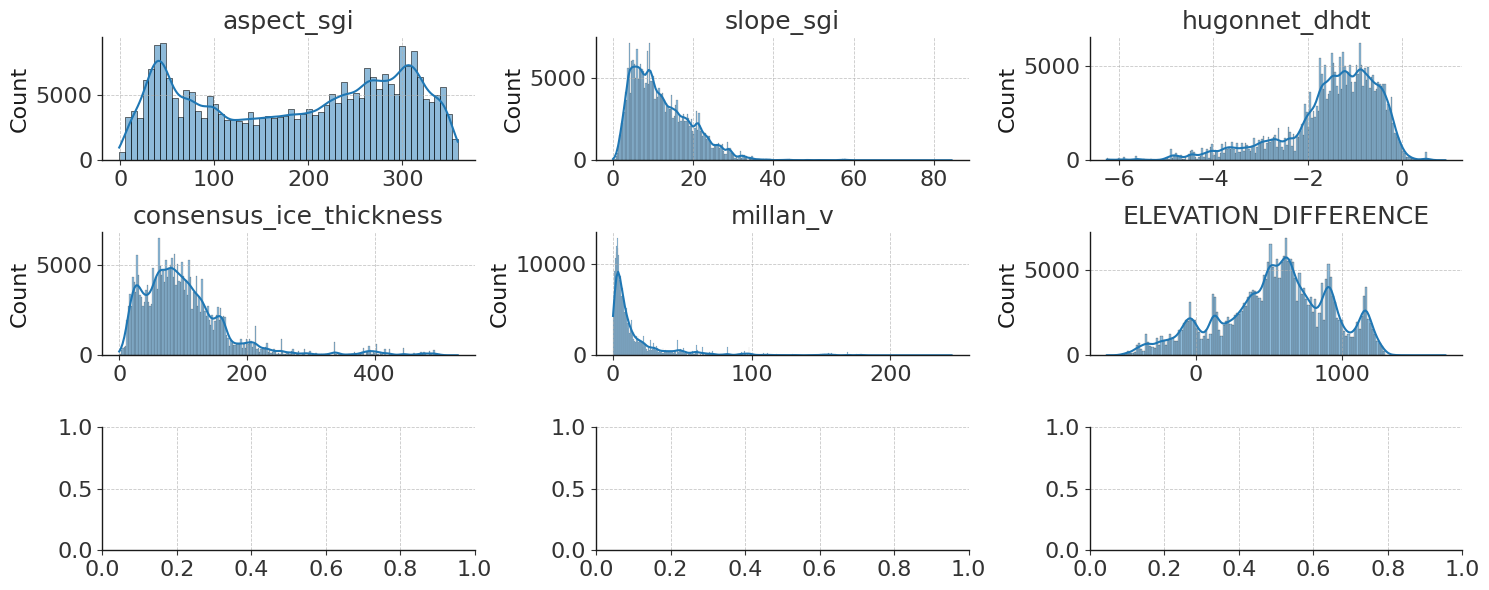

In [11]:
# Plot the distribution of the topo variables:
df = dataloader_gl.data
fig, axs = plt.subplots(3, 3, figsize=(15, 6))
for i, var in enumerate(vois_topographical + ['ELEVATION_DIFFERENCE']):
    ax = axs.flatten()[i]
    sns.histplot(df[var], ax=ax, kde=True)
    ax.set_xlabel('')
    ax.set_title(var)
plt.tight_layout()

## Blocking on glaciers:

In [12]:
test_glaciers = [
    'tortin', 'plattalva', 'sanktanna', 'schwarzberg', 'hohlaub', 'pizol',
    'corvatsch', 'tsanfleuron', 'forno'
]

# Ensure all test glaciers exist in the dataset
existing_glaciers = set(dataloader_gl.data.GLACIER.unique())
missing_glaciers = [g for g in test_glaciers if g not in existing_glaciers]

if missing_glaciers:
    print(
        f"Warning: The following test glaciers are not in the dataset: {missing_glaciers}"
    )

# Define training glaciers correctly
train_glaciers = [i for i in existing_glaciers if i not in test_glaciers]

data_test = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(test_glaciers)]
print('Size of test data:', len(data_test))

data_train = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(
    train_glaciers)]
print('Size of train data:', len(data_train))

if len(data_train) == 0:
    print("Warning: No training data available!")
else:
    test_perc = (len(data_test) / len(data_train)) * 100
    print('Percentage of test size: {:.2f}%'.format(test_perc))

# Number of annual versus winter measurements:
print('Train:')
print('Number of winter and annual samples:', len(data_train))
print('Number of annual samples:',
      len(data_train[data_train.PERIOD == 'annual']))
print('Number of winter samples:',
      len(data_train[data_train.PERIOD == 'winter']))

# Same for test
data_test_annual = data_test[data_test.PERIOD == 'annual']
data_test_winter = data_test[data_test.PERIOD == 'winter']

print('Test:')
print('Number of winter and annual samples:', len(data_test))
print('Number of annual samples:', len(data_test_annual))
print('Number of winter samples:', len(data_test_winter))

print('Total:')
print('Number of monthly rows:', len(dataloader_gl.data))
print('Number of annual rows:',
      len(dataloader_gl.data[dataloader_gl.data.PERIOD == 'annual']))
print('Number of winter rows:',
      len(dataloader_gl.data[dataloader_gl.data.PERIOD == 'winter']))

Size of test data: 29024
Size of train data: 251696
Percentage of test size: 11.53%
Train:
Number of winter and annual samples: 251696
Number of annual samples: 83148
Number of winter samples: 168548
Test:
Number of winter and annual samples: 29024
Number of annual samples: 7722
Number of winter samples: 21302
Total:
Number of monthly rows: 280720
Number of annual rows: 90870
Number of winter rows: 189850


#### Heatmap annual:

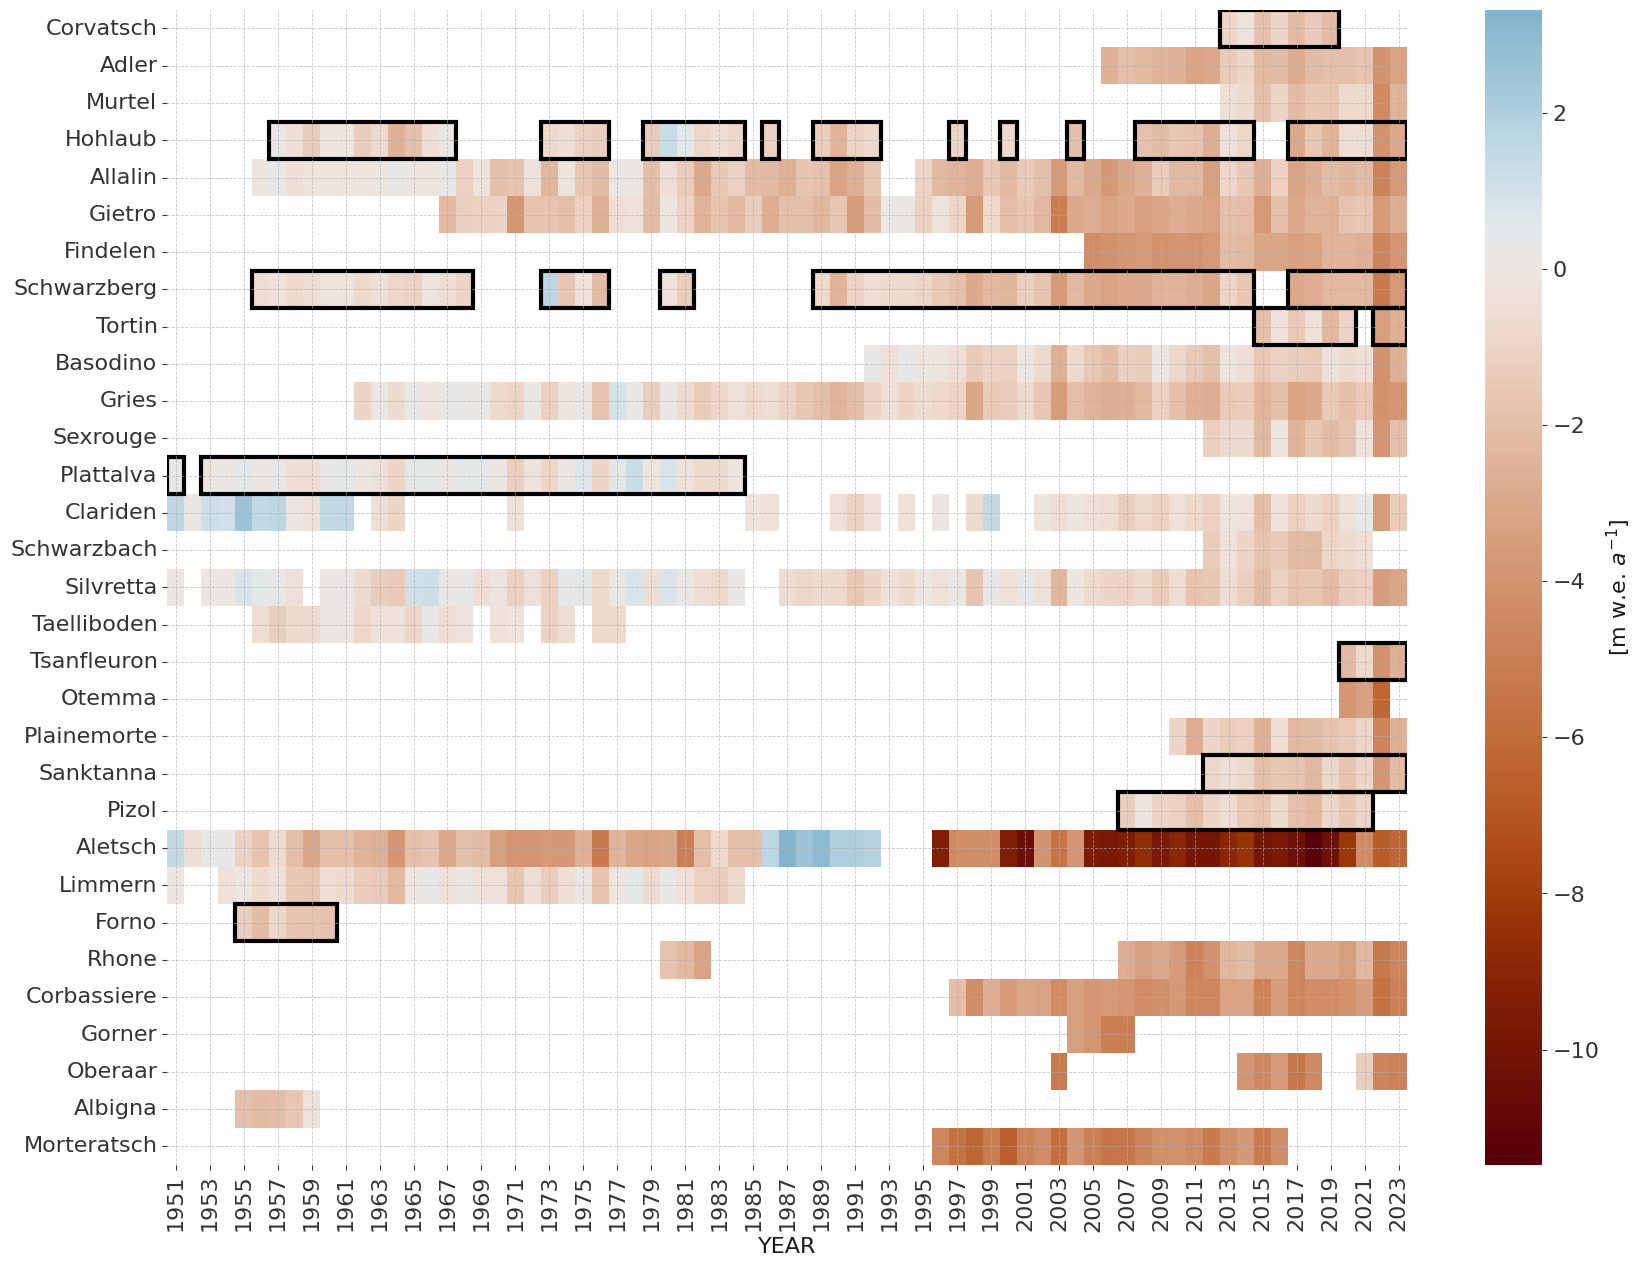

In [13]:
plotHeatmap(test_glaciers, data_glamos, glacierCap, period='annual')

#### Heatmap winter:

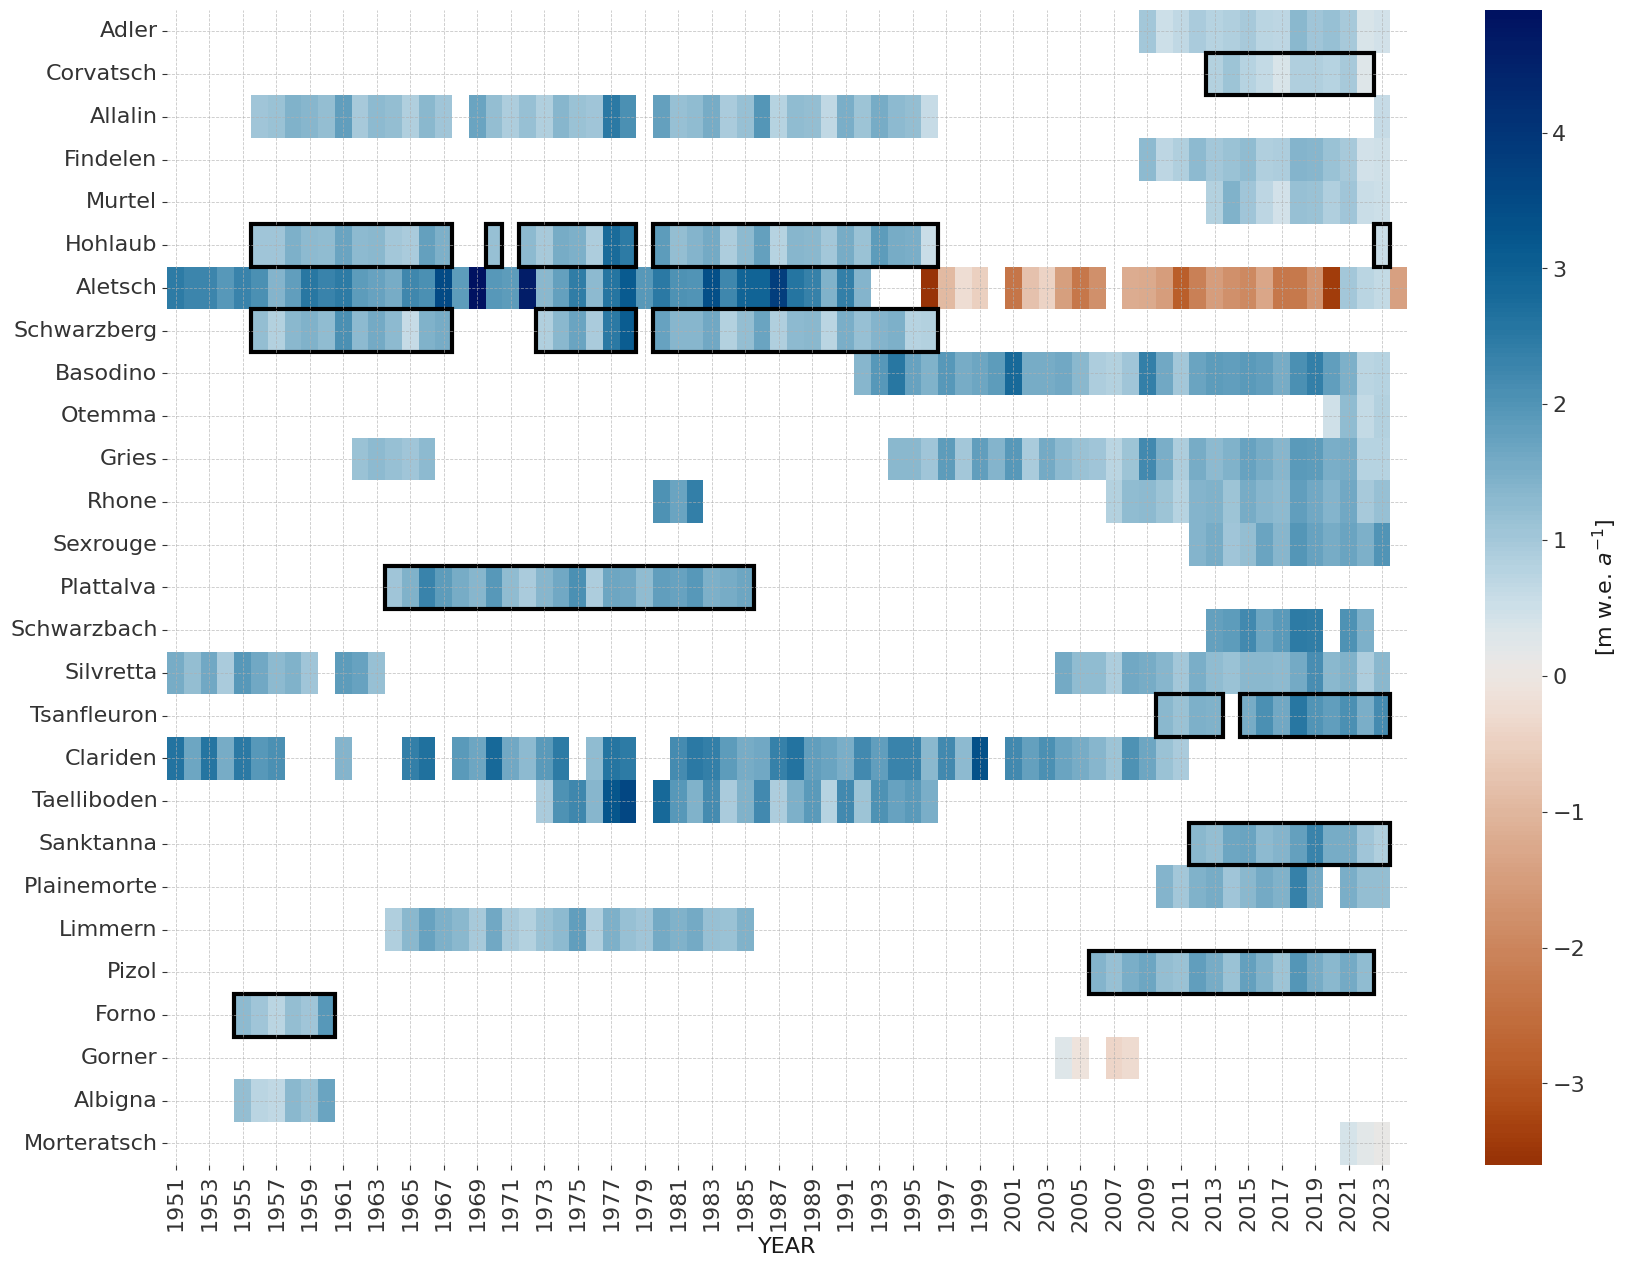

In [14]:
plotHeatmap(test_glaciers, data_glamos, glacierCap, period='winter')

#### CV splits:

Test glaciers: (9) ['corvatsch' 'forno' 'hohlaub' 'pizol' 'plattalva' 'sanktanna'
 'schwarzberg' 'tortin' 'tsanfleuron']
Percentage of test size: 11.53%
Size of test set: 29024
Train glaciers: (22) ['adler' 'albigna' 'aletsch' 'allalin' 'basodino' 'clariden' 'corbassiere'
 'findelen' 'gietro' 'gorner' 'gries' 'limmern' 'morteratsch' 'murtel'
 'oberaar' 'otemma' 'plainemorte' 'rhone' 'schwarzbach' 'sexrouge'
 'silvretta' 'taelliboden']
Size of train set: 251696


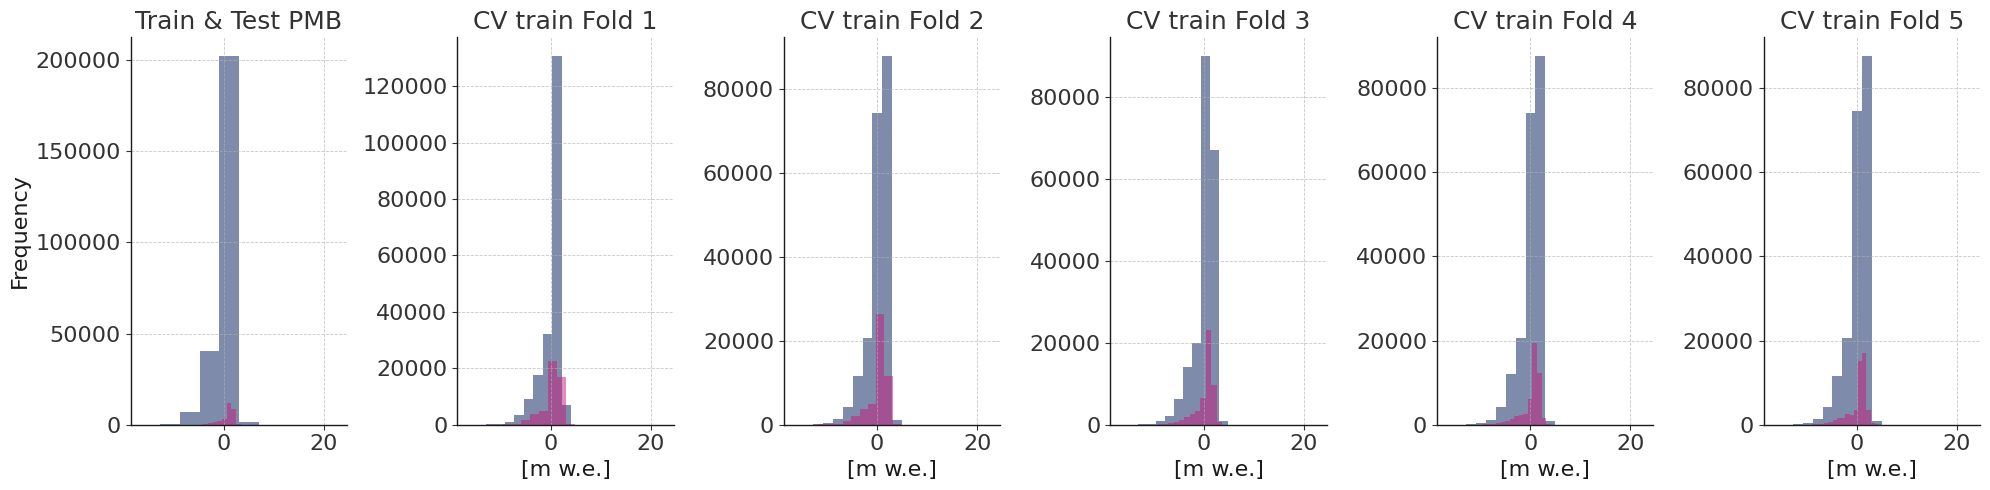

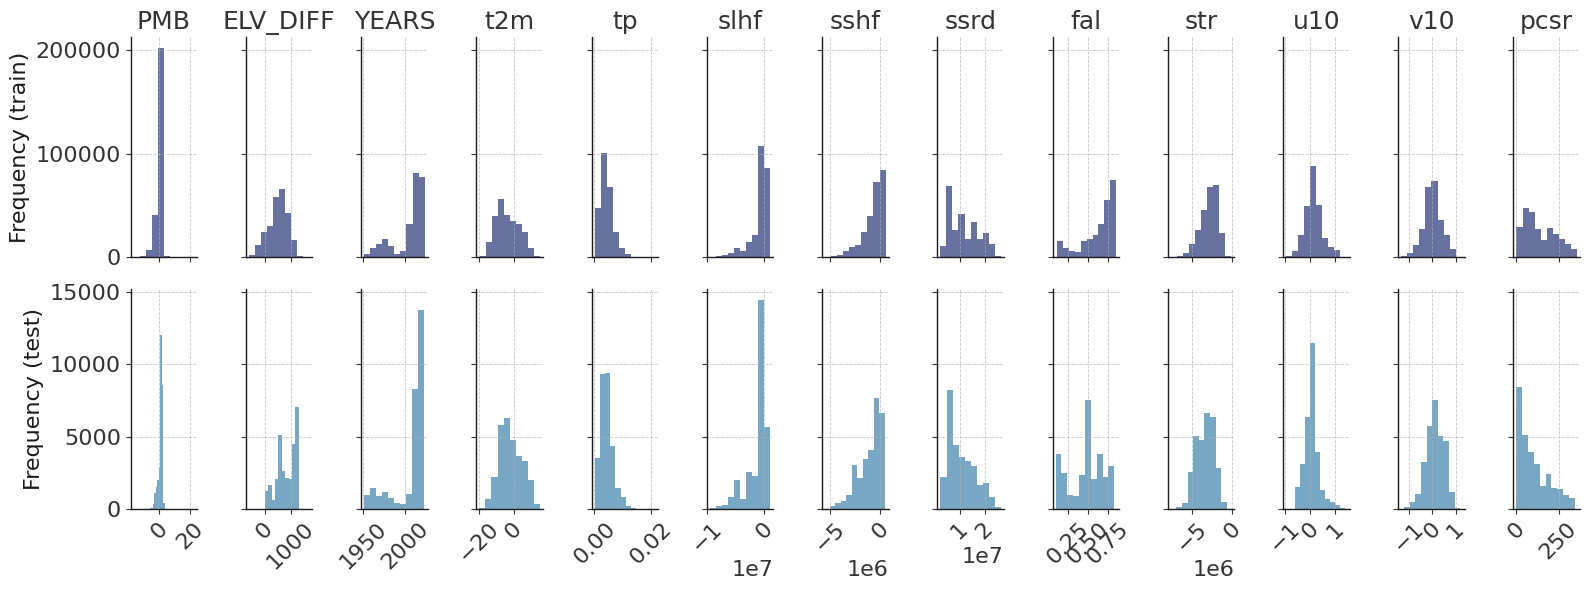

In [15]:
splits, test_set, train_set = getCVSplits(dataloader_gl,
                                          test_split_on='GLACIER',
                                          test_splits=test_glaciers,
                                          random_state=cfg.seed)

print('Test glaciers: ({}) {}'.format(len(test_set['splits_vals']),
                                      test_set['splits_vals']))
test_perc = (len(test_set['df_X']) / len(train_set['df_X'])) * 100
print('Percentage of test size: {:.2f}%'.format(test_perc))
print('Size of test set:', len(test_set['df_X']))
print('Train glaciers: ({}) {}'.format(len(train_set['splits_vals']),
                                       train_set['splits_vals']))
print('Size of train set:', len(train_set['df_X']))

visualiseSplits(test_set['y'], train_set['y'], splits)
visualiseInputs(train_set, test_set, vois_climate)

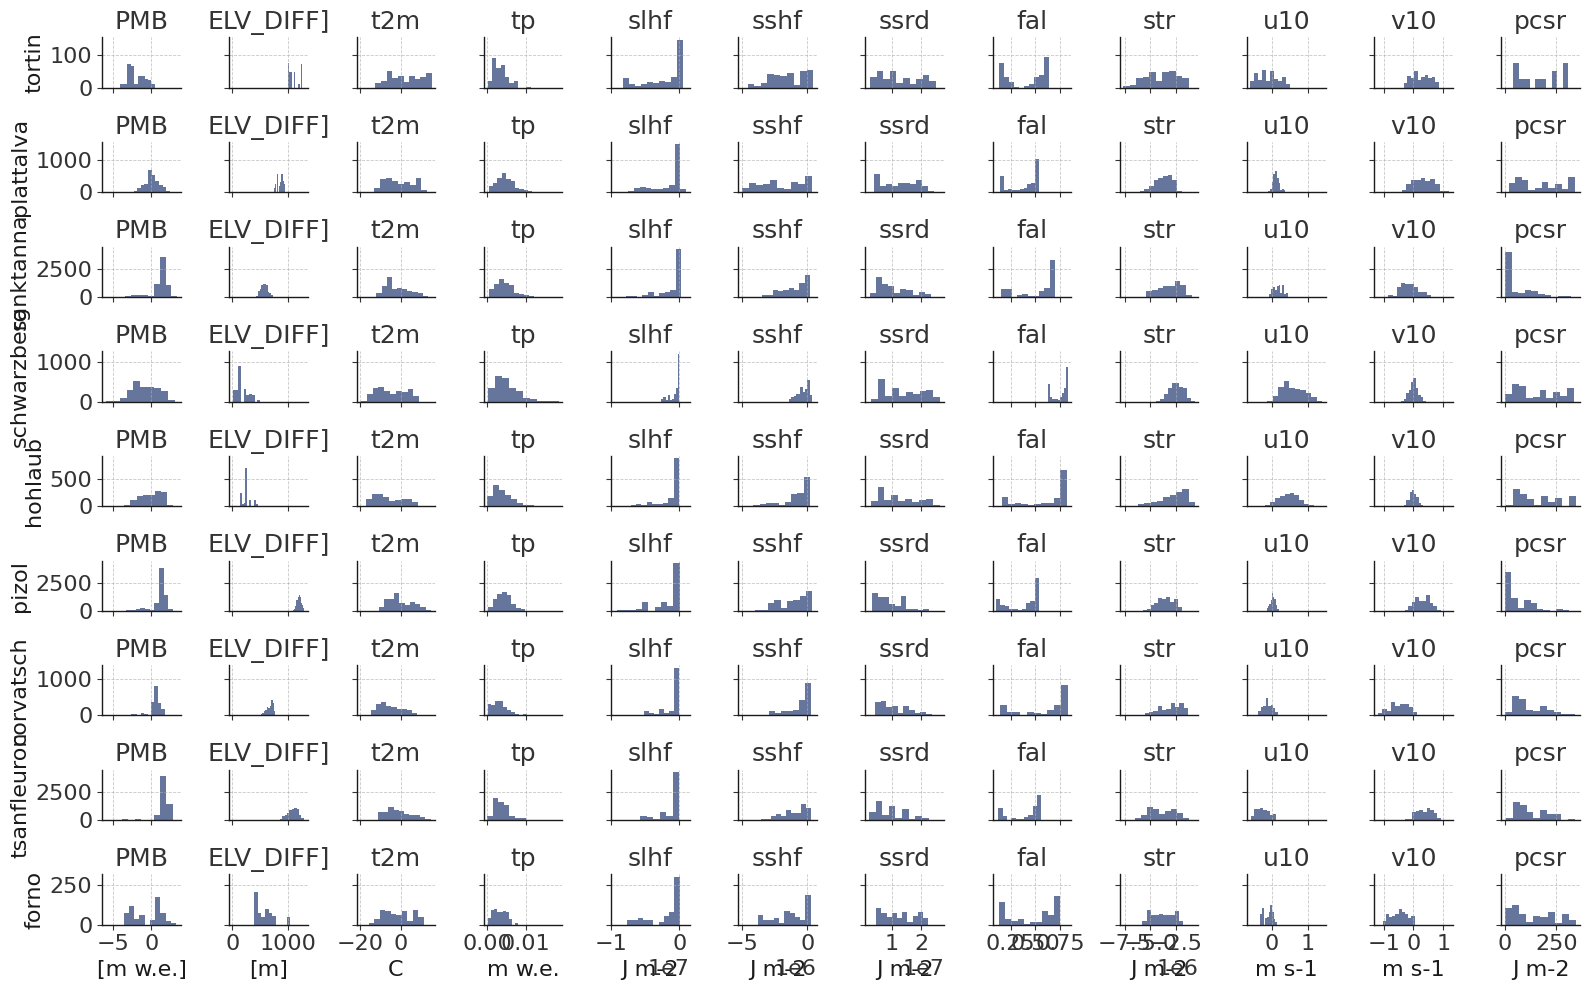

In [16]:
# plot distributions of test glaciers:
f, ax = plt.subplots(len(test_glaciers),
                     len(vois_climate) + 3,
                     figsize=(16, 10),
                     sharey='row',
                     sharex='col')

for i, test_gl in enumerate(test_glaciers):
    test_df_gl = test_set['df_X'][test_set['df_X'].GLACIER == test_gl]
    test_df_gl['POINT_BALANCE'].plot.hist(ax=ax[i, 0],
                                          color=color_dark_blue,
                                          alpha=0.6,
                                          density=False)
    ax[i, 0].set_title('PMB')
    ax[i, 0].set_ylabel(test_gl)
    ax[i, 0].set_xlabel('[m w.e.]')
    test_df_gl['ELEVATION_DIFFERENCE'].plot.hist(ax=ax[i, 1],
                                                 color=color_dark_blue,
                                                 alpha=0.6,
                                                 density=False)
    ax[i, 1].set_title('ELV_DIFF]')
    ax[i, 1].set_xlabel('[m]')

    for j, voi_clim in enumerate(vois_climate + ['pcsr']):
        ax[i, 2 + j].set_title(voi_clim)
        test_df_gl[voi_clim].plot.hist(ax=ax[i, 2 + j],
                                       color=color_dark_blue,
                                       alpha=0.6,
                                       density=False)
        ax[i, 2 + j].set_xlabel(vois_units[voi_clim])

plt.tight_layout()

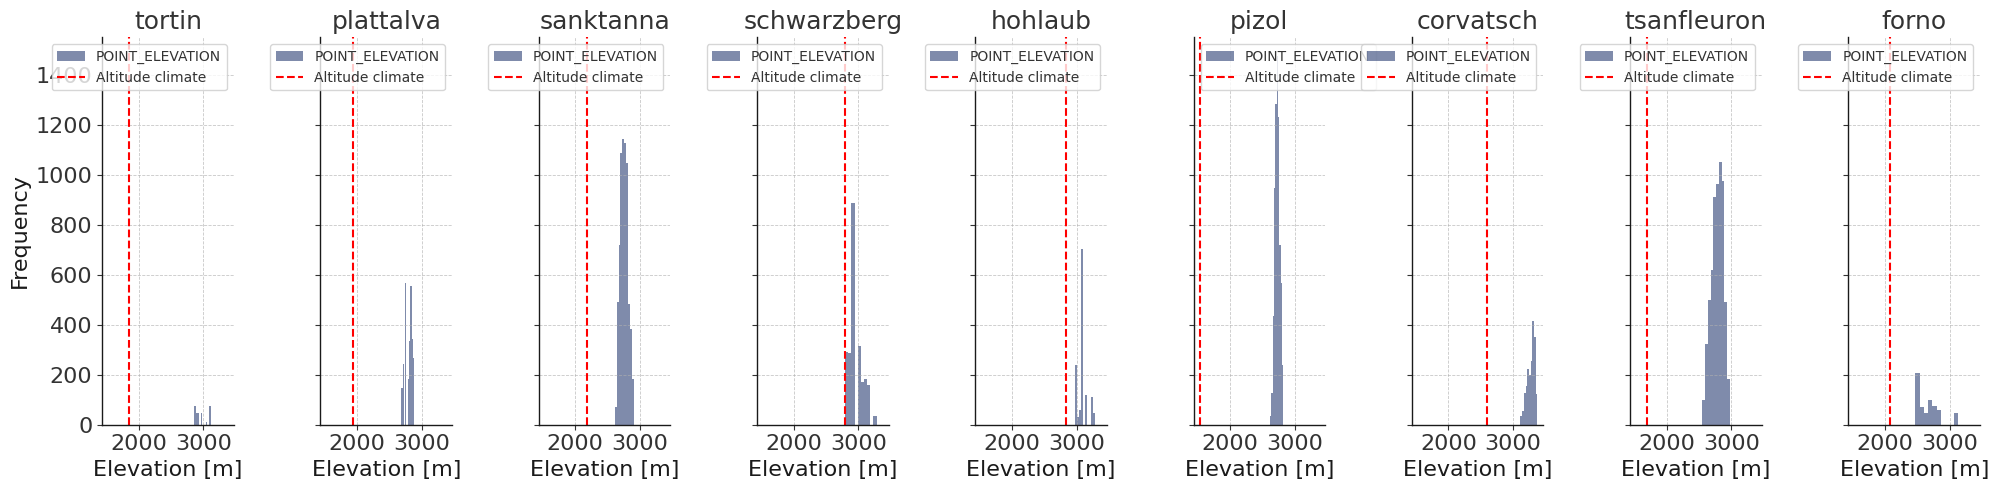

In [17]:
f, ax = plt.subplots(1,
                     len(test_glaciers),
                     figsize=(20, 5),
                     sharey='row',
                     sharex='row')

for i, test_gl in enumerate(test_glaciers):
    test_df_gl = test_set['df_X'][test_set['df_X'].GLACIER == test_gl]
    test_df_gl.POINT_ELEVATION.plot.hist(color=color_dark_blue,
                                         alpha=0.5,
                                         density=False,
                                         ax=ax[i])
    # add vertical line for altitude climate
    alt_climate = test_df_gl.ALTITUDE_CLIMATE.mean()
    ax[i].axvline(x=alt_climate,
                  color='red',
                  linestyle='--',
                  label='Altitude climate')
    ax[i].set_xlabel('Elevation [m]')
    ax[i].legend()
    ax[i].set_title(test_gl)
plt.tight_layout()

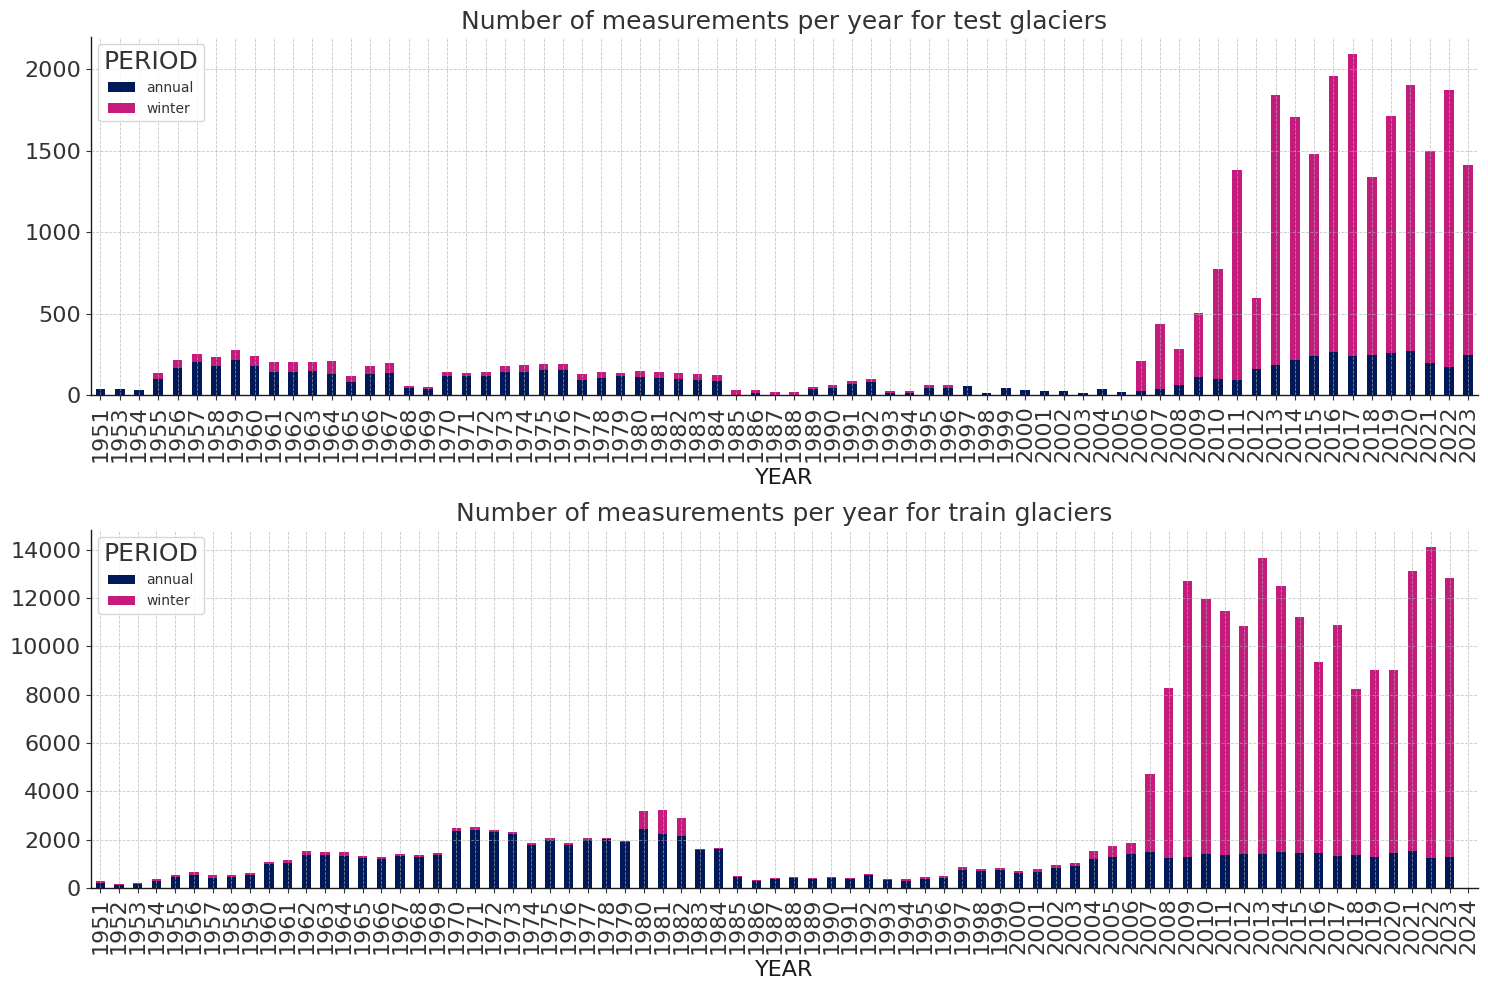

In [18]:
# Number of measurements per year:
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
data_test.groupby(['YEAR', 'PERIOD']).size().unstack().plot(
    kind='bar', stacked=True, color=[color_dark_blue, color_pink], ax=ax[0])
ax[0].set_title('Number of measurements per year for test glaciers')

# Number of measurements per year:
data_train.groupby(['YEAR', 'PERIOD']).size().unstack().plot(
    kind='bar', stacked=True, color=[color_dark_blue, color_pink], ax=ax[1])
ax[1].set_title('Number of measurements per year for train glaciers')
plt.tight_layout()

## XGBoost:

In [19]:
# Grid search
# For each of the XGBoost parameter, define the grid range
param_grid = {
    'max_depth': [2, 3, 4, 5, 6, 7, 8],
    'n_estimators':
    [50, 100, 200, 300, 400, 500, 600,
     700],  # number of trees (too many = overfitting, too few = underfitting)
    'learning_rate': [0.01, 0.1, 0.15, 0.2, 0.25, 0.3]
}

param_init = {}
param_init['device'] = 'cuda:0'
param_init['tree_method'] = 'hist'
param_init["random_state"] = cfg.seed
param_init["n_jobs"] = cfg.numJobs

# vois_climate = [
#     't2m_corr', 'tp_corr', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10',
#     'v10'
# ]

vois_climate = [
    't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10',
    'v10'
]

vois_topographical = [
    "aspect_sgi",
    "slope_sgi",
    "hugonnet_dhdt",
    "consensus_ice_thickness",
    "millan_v",
]

### Grid search:

In [20]:
%%time
# Feature columns:
feature_columns = [
    'ELEVATION_DIFFERENCE'
] + list(vois_climate) + list(vois_topographical) + ['pcsr']
all_columns = feature_columns + cfg.fieldsNotFeatures
df_X_train_subset = train_set['df_X'][all_columns]
print('Shape of training dataset:', df_X_train_subset.shape)
print('Shape of testing dataset:', test_set['df_X'][all_columns].shape)
print('Running with features:', feature_columns)

RUN = False
if RUN:
    # Create a CustomXGBoostRegressor instance
    custom_xgboost = mbm.models.CustomXGBoostRegressor(cfg, **param_init)
    custom_xgboost.randomsearch(
        parameters=param_grid,
        n_iter=45,
        splits=splits,
        features=df_X_train_subset,
        targets=train_set['y'],
    )

    # save best model
    custom_xgboost.save_model(f'xgb_gl_split_sgi_corr.pkl')
else:
    # read model
    custom_xgboost = mbm.models.CustomXGBoostRegressor(cfg)
    custom_xgboost.load_model(
        f'xgb_gl_split_sgi_corr.pkl')  # model with SGI aspect&slope

# Get best parameters and estimator
best_params = custom_xgboost.param_search.best_params_
best_estimator = custom_xgboost.param_search.best_estimator_
print("Best parameters:\n", best_params)
print("Best score:\n", custom_xgboost.param_search.best_score_)

# Make predictions on test:
# Set to CPU for predictions:
best_estimator_cpu = best_estimator.set_params(device='cpu')

# Make predictions on test
features_test, metadata_test = best_estimator_cpu._create_features_metadata(test_set['df_X'][all_columns])
y_pred = best_estimator_cpu.predict(features_test)
print('Shape of the test:', features_test.shape)

# Make predictions aggr to meas ID:
y_pred_agg = best_estimator_cpu.aggrPredict(metadata_test, features_test)

# Calculate scores
score = best_estimator_cpu.score(test_set['df_X'][all_columns],
                                 test_set['y'])  # negative
print('Overall score:', np.abs(score))

Shape of training dataset: (251696, 27)
Shape of testing dataset: (29024, 27)
Running with features: ['ELEVATION_DIFFERENCE', 't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10', 'aspect_sgi', 'slope_sgi', 'hugonnet_dhdt', 'consensus_ice_thickness', 'millan_v', 'pcsr']
Best parameters:
 {'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.01}
Best score:
 -0.21775680588821986
Shape of the test: (29024, 16)
Overall score: 0.41609538807888125
CPU times: user 3.67 s, sys: 193 ms, total: 3.86 s
Wall time: 352 ms


In [21]:
# visualiseValPreds(best_estimator, splits, train_set, feature_columns)

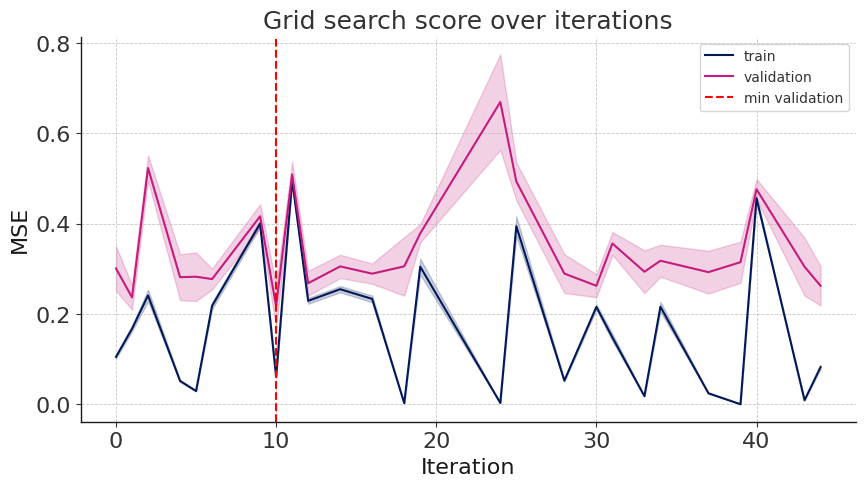

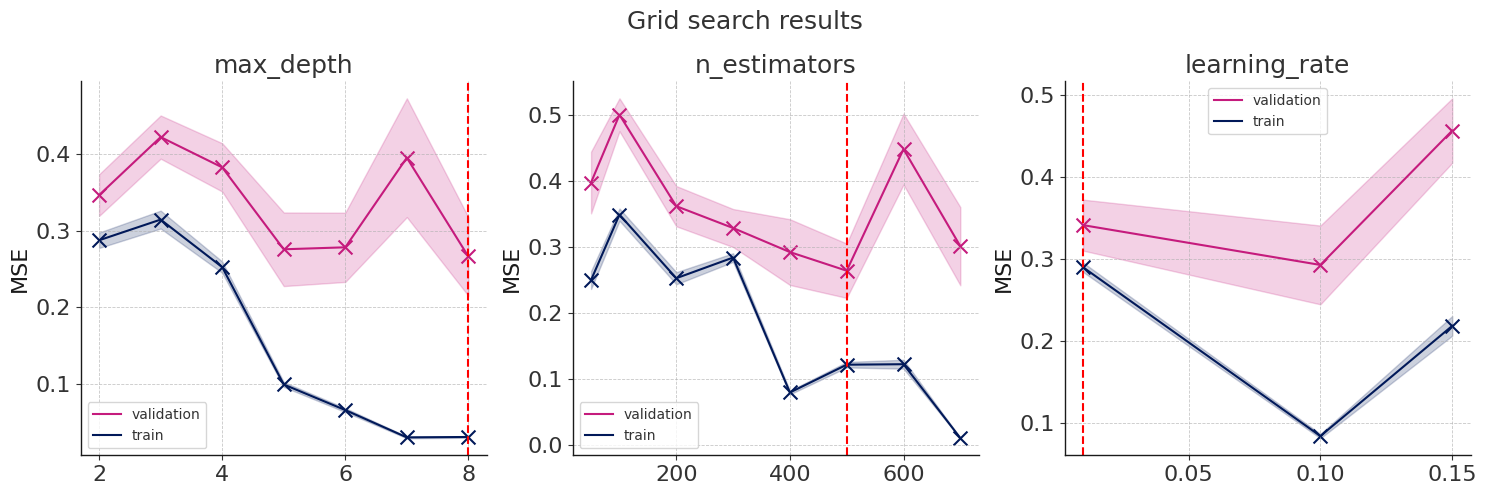

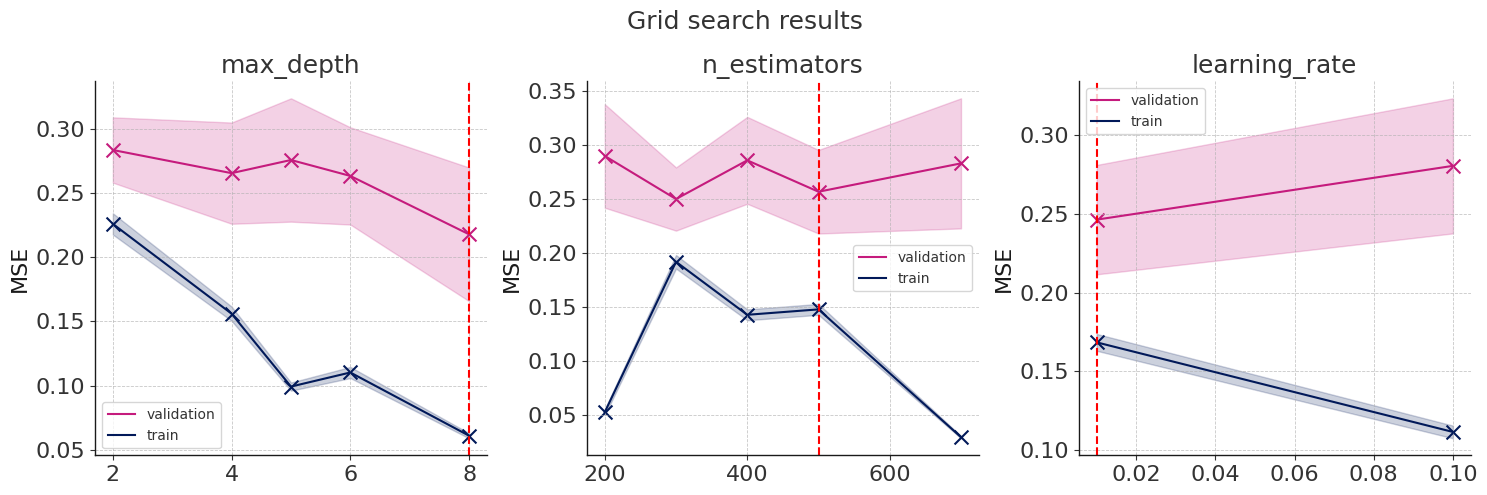

In [22]:
plotGridSearchScore(cv_results_=custom_xgboost.param_search.cv_results_, lossType=cfg.loss)
plotGridSearchParams(custom_xgboost.param_search.cv_results_, param_grid, lossType=cfg.loss)
plotGridSearchParams(custom_xgboost.param_search.cv_results_, param_grid, lossType=cfg.loss, N=10)

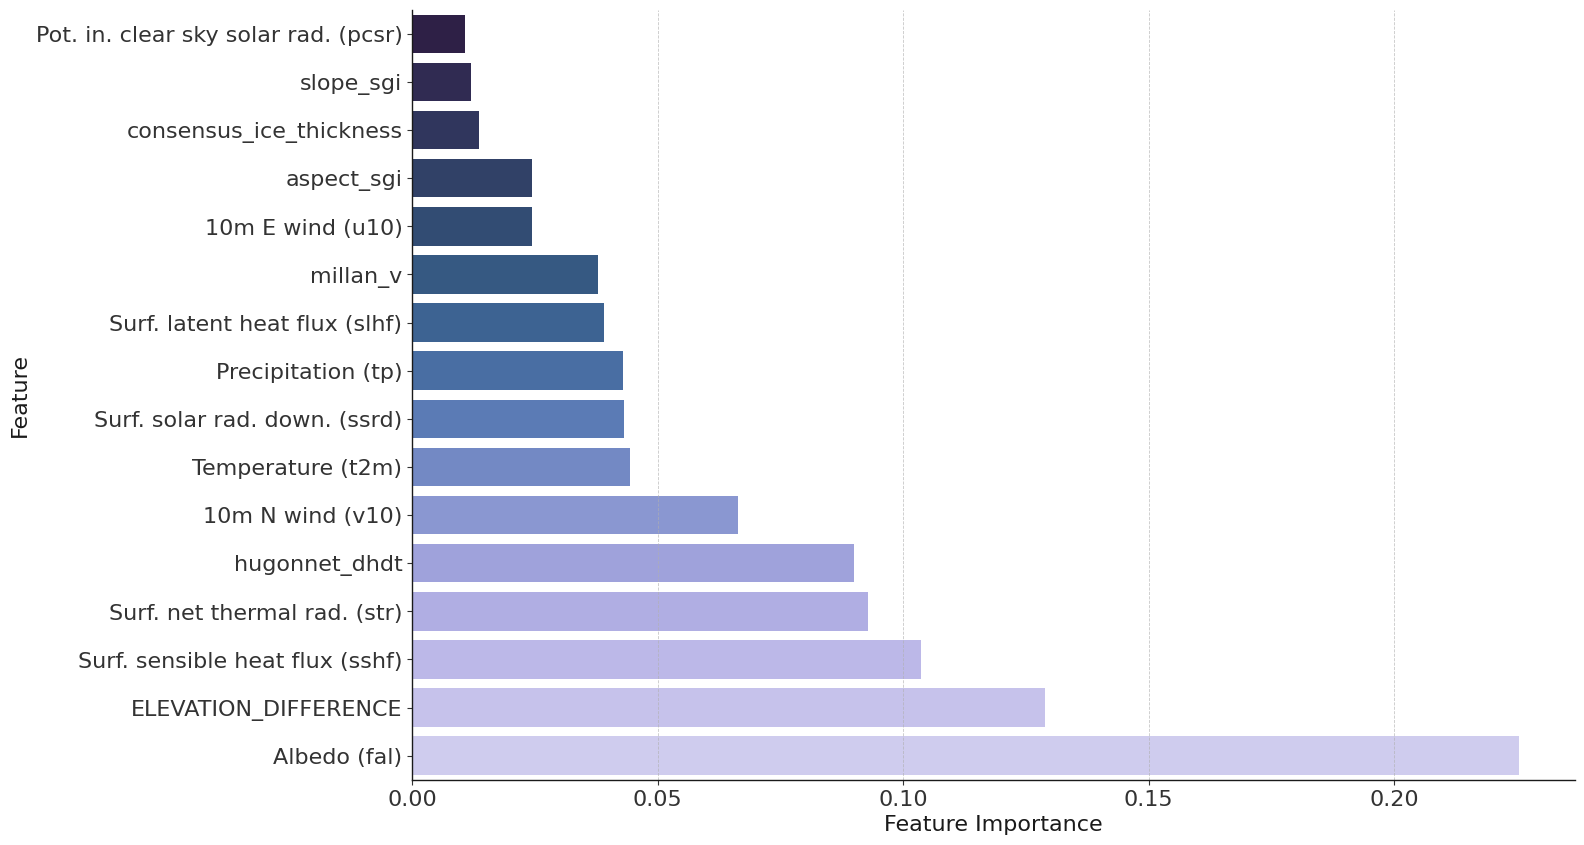

In [23]:
FIPlot(best_estimator, feature_columns, vois_climate)

#### Predictions of best parameters:

Shape of the test: (29024, 16)
{'corvatsch': '#a6cee3', 'forno': '#1f78b4', 'hohlaub': '#b2df8a', 'pizol': '#33a02c', 'plattalva': '#fb9a99', 'sanktanna': '#e31a1c', 'schwarzberg': '#fdbf6f', 'tortin': '#ff7f00', 'tsanfleuron': '#cab2d6'}


TypeError: got an unexpected keyword argument 'squared'

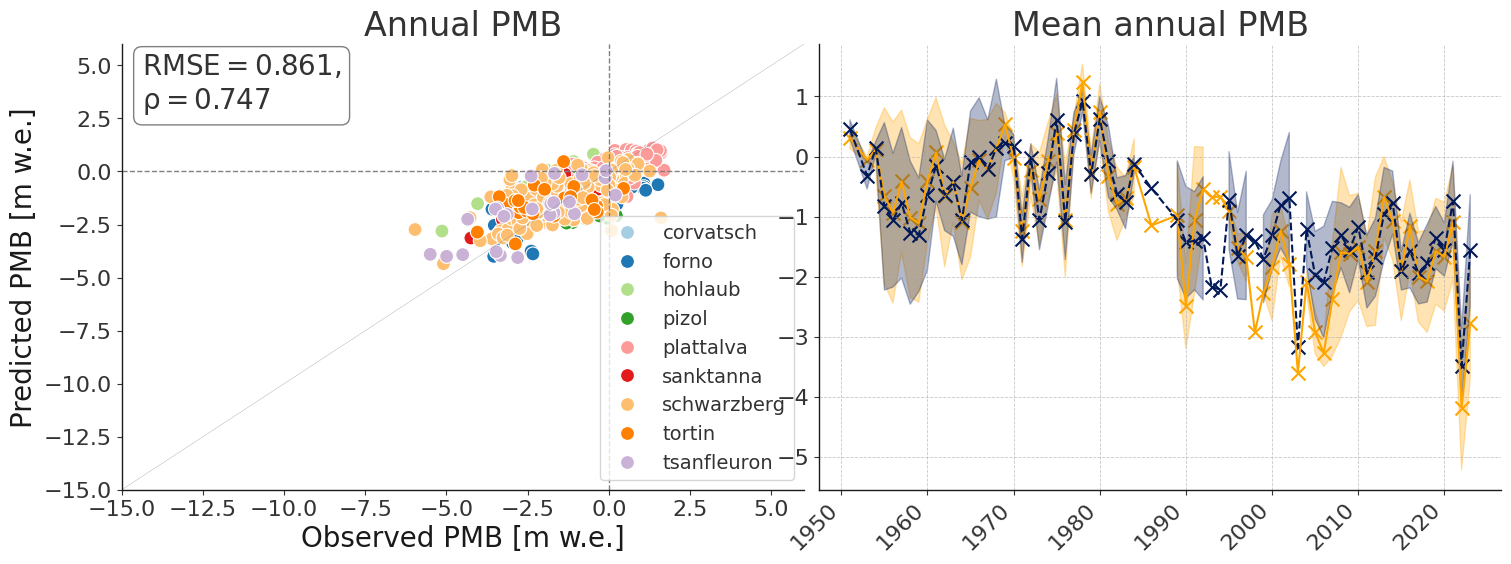

In [24]:
# Make predictions on test:
# Set to CPU for predictions:
best_estimator_cpu = best_estimator.set_params(device='cpu')

features_test, metadata_test = best_estimator_cpu._create_features_metadata(test_set['df_X'][all_columns])
y_pred = best_estimator_cpu.predict(features_test)
print('Shape of the test:', features_test.shape)

y_pred_agg = best_estimator_cpu.aggrPredict(metadata_test, features_test)
grouped_ids = getDfAggregatePred(test_set, y_pred_agg, all_columns)
PlotPredictions(grouped_ids, y_pred, metadata_test, test_set,
                best_estimator_cpu)
plt.suptitle(f'XGBoost tested on {test_glaciers}', fontsize=20)
plt.tight_layout()

### Predictions of custom parameters:

In [ ]:
custom_params = {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 800}

# Feature columns:
feature_columns = [
    'ELEVATION_DIFFERENCE'
] + list(vois_climate) + list(vois_topographical) + ['pcsr']
all_columns = feature_columns + cfg.fieldsNotFeatures
df_X_train_subset = train_set['df_X'][all_columns]
print('Shape of training dataset:', df_X_train_subset.shape)
print('Shape of testing dataset:', test_set['df_X'][all_columns].shape)
print('Running with features:', feature_columns)

params = {**param_init, **custom_params}
print(params)
custom_model = mbm.models.CustomXGBoostRegressor(cfg, **params)

# Fit on train data:
custom_model.fit(train_set['df_X'][all_columns], train_set['y'])

# Make predictions on test
custom_model = custom_model.set_params(device='cpu')
features_test, metadata_test = custom_model._create_features_metadata(test_set['df_X'][all_columns])
y_pred = custom_model.predict(features_test)
print('Shape of the test:', features_test.shape)

# Make predictions aggr to meas ID:
y_pred_agg = custom_model.aggrPredict(metadata_test, features_test)

# Calculate scores
score = custom_model.score(test_set['df_X'][all_columns],
                           test_set['y'])  # negative
print('Overall score:', np.abs(score))

grouped_ids = getDfAggregatePred(test_set, y_pred_agg, all_columns)
PlotPredictions(grouped_ids, y_pred, metadata_test, test_set, custom_model)
plt.suptitle(f'MBM tested on {test_glaciers}', fontsize=20)
plt.tight_layout()

In [ ]:
# Aggregate predictions to annual or winter:
PlotIndividualGlacierPredVsTruth(grouped_ids, figsize=(20, 15))

In [ ]:
FIPlot(custom_model, feature_columns, vois_climate)

## Extrapolate in space


### Geodetic MB:

In [ ]:
# read geodetic MB:
geodeticMB = pd.read_csv(path_geodetic_MB_glamos + 'dV_DOI2024_allcomb.csv')

# filter to glaciers
all_gl = dataloader_gl.data.GLACIER.unique()

# get rgi of those glaciers:
rgi_gl = data_glamos[data_glamos.GLACIER.isin(all_gl)].RGIId.unique()
sgi_gl = [
    rgi_df[rgi_df['rgi_id.v6'] == rgi]['sgi-id'].values[0] for rgi in rgi_gl
]
geodeticMB = geodeticMB[geodeticMB['SGI-ID'].isin(sgi_gl)]

# Add glacierName to geodeticMB
# based  on SGI-ID
glacierNames = [
    rgi_df[rgi_df['sgi-id'] == sgi_id].index[0]
    for sgi_id in geodeticMB['SGI-ID'].values
]
geodeticMB['glacierName'] = glacierNames

# replace claridenL by clariden
geodeticMB['glacierName'] = geodeticMB['glacierName'].apply(
    lambda x: 'clariden' if x == 'claridenL' else x)

# get years per glacier
years_start_per_gl = geodeticMB.groupby(
    'glacierName')['Astart'].unique().apply(list).to_dict()
years_end_per_gl = geodeticMB.groupby('glacierName')['A_end'].unique().apply(
    list).to_dict()

periods_per_glacier = defaultdict(list)
geoMB_per_glacier = defaultdict(list)
# Iterate through the DataFrame rows
for _, row in geodeticMB.iterrows():
    glacierName = row['glacierName']
    start_year = row['Astart']
    end_year = row['A_end']
    geoMB = row['Bgeod']

    # Append the (start, end) tuple to the glacier's list
    periods_per_glacier[glacierName].append((start_year, end_year))
    geoMB_per_glacier[glacierName].append(geoMB)

### Glacier wide MB: 
Compute 2D fields.

#### List of glaciers to compute:

In [ ]:
glDirect = [
    re.search(r'xr_direct_(.*?)\.nc', f).group(1)
    for f in os.listdir(path_pcsr + 'csv/')
]
data_glamos = data_glamos[data_glamos.GLACIER.isin(glDirect)]
glacier_list = list(data_glamos.GLACIER.unique())
print('Number of glaciers with pcsr:', len(glacier_list))

satellite_glaciers = [
    'adler', 'aletsch', 'allalin', 'basodino', 'clariden', 'findelen', 'gries',
    'hohlaub', 'limmern', 'oberaar', 'plattalva', 'rhone', 'sanktanna',
    'schwarzbach', 'schwarzberg'
]
geodetic_glaciers = geodeticMB.glacierName.unique()
print('Number of glaciers with geodetic MB:', len(geodetic_glaciers))

# Intersection of both
common_glaciers = list(set(geodetic_glaciers) & set(glacier_list))
print('Number of common glaciers:', len(common_glaciers))

# Sort glaciers by area
gl_area = get_gl_area()
gl_area['clariden'] = gl_area['claridenL']


# Sort the lists by area if available in gl_area
def sort_by_area(glacier_list, gl_area):
    return sorted(glacier_list, key=lambda g: gl_area.get(g, 0), reverse=False)

glacier_list = sort_by_area(common_glaciers, gl_area)
glacier_list

### GLAMOS grids:

#### With OGGM vars:

##### Corrected T & P:

In [ ]:
RUN = False
if RUN:
    # Define paths
    path_glacier_grid_glamos = '../../../data/GLAMOS/topo/gridded_topo_inputs/GLAMOS_grid_with_oggm_vars/'
    path_save_glw = 'results/nc/glamos/OGGM_vars/TP_corr_T2m_corr/'
    path_xr_grids = '../../../data/GLAMOS/topo/GLAMOS_DEM/xr_masked_grids/'  # GLAMOS DEMs

    emptyfolder(path_save_glw)

    # Feature columns
    vois_climate = [
        't2m_corr', 'tp_corr', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10'
    ]
    feature_columns = [
        'ELEVATION_DIFFERENCE'
    ] + list(vois_climate) + list(vois_topographical) + ['pcsr']
    all_columns = feature_columns + cfg.fieldsNotFeatures
    print('Running for feature columns:', all_columns)

    for glacier_name in glacier_list:
        glacier_path = os.path.join(path_glacier_grid_glamos, glacier_name)

        if not os.path.exists(glacier_path):
            print(f"Folder not found for {glacier_name}, skipping...")
            continue

        glacier_files = sorted(
            [f for f in os.listdir(glacier_path) if glacier_name in f])

        print(f"Processing {glacier_name} ({len(glacier_files)} files)")

        for file_name in tqdm(glacier_files,
                            desc=f"Processing {glacier_name}",
                            leave=False):
            process_glacier_file(cfg, custom_model, glacier_name, file_name,
                                path_save_glw, path_xr_grids, all_columns)

In [ ]:
# open xarray
xr.open_dataset(path_save_glw +
                'aletsch/aletsch_2008_annual.nc').pred_masked.plot()

##### Normal T & P:

In [ ]:
RUN = True
if RUN:
    # Define paths
    path_glacier_grid_glamos = '../../../data/GLAMOS/topo/gridded_topo_inputs/GLAMOS_grid_with_oggm_vars/'
    path_save_glw = 'results/nc/glamos/OGGM_vars/TP_T2m/'
    path_xr_grids = '../../../data/GLAMOS/topo/GLAMOS_DEM/xr_masked_grids/'  # GLAMOS DEMs

    #emptyfolder(path_save_glw)

    # Feature columns
    vois_climate = [
        't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10'
    ]
    feature_columns = [
        'ELEVATION_DIFFERENCE'
    ] + list(vois_climate) + list(vois_topographical) + ['pcsr']
    all_columns = feature_columns + cfg.fieldsNotFeatures
    print('Running for feature columns:', all_columns)

    #for glacier_name in glacier_list:
    for glacier_name in ['aletsch']:
        glacier_path = os.path.join(path_glacier_grid_glamos, glacier_name)

        if not os.path.exists(glacier_path):
            print(f"Folder not found for {glacier_name}, skipping...")
            continue

        glacier_files = sorted(
            [f for f in os.listdir(glacier_path) if glacier_name in f])

        print(f"Processing {glacier_name} ({len(glacier_files)} files)")

        for file_name in tqdm(glacier_files,
                            desc=f"Processing {glacier_name}",
                            leave=False):
            process_glacier_file(cfg, custom_model, glacier_name, file_name,
                                path_save_glw, path_xr_grids, all_columns)

In [ ]:
# open xarray
xr.open_dataset(path_save_glw +
                'aletsch/aletsch_2008_annual.nc').pred_masked.plot()